
# Spherical Projection Ray Tracing

This section extends the ray tracing to a spherical projection, which is more suitable for wide-field cosmological surveys. Instead of extracting 2D Cartesian density planes, we now paint the particle
distribution onto spherical shells and compute spherical convergence maps.

**Key Differences:**
-   **Spherical Density Planes:** Particles are painted onto Healpix maps at different comoving distances from the observer.
-   **Spherical Convergence:** The lensing convergence is computed on these spherical maps.


In [1]:

import os
os.environ["JC_CACHE"] = "off"
os.environ["JAX_PLATFORM_NAME"] = "cpu"

from functools import partial
from typing import Any, NamedTuple

import jax
import jax.numpy as jnp
import jax_cosmo as jc
import jax_cosmo.constants as constants
from diffrax import ODETerm, RecursiveCheckpointAdjoint, SaveAt, diffeqsolve , SemiImplicitEuler , ConstantStepSize
from jax.scipy.ndimage import map_coordinates
from jax_cosmo.scipy.integrate import simps
from jaxpm.distributed import fft3d, ifft3d, normal_field, uniform_particles
from jaxpm.kernels import fftk
from jaxpm.painting import cic_paint_2d , cic_paint_dx
from jaxpm.pm import growth_factor, growth_rate, pm_forces , linear_field  ,lpt , make_diffrax_ode
from jaxpm.growth import E
from jaxpm.utils import gaussian_smoothing
from jaxpm.ode import symplectic_ode
from jaxpm.lensing import spherical_density_fn , spherical_convergence_Born
import matplotlib.pyplot as plt
from jaxpm.utils import gaussian_smoothing

In [2]:
Planck18 = partial(
    jc.Cosmology,
    # Omega_m = 0.3111
    Omega_c=0.2607,
    Omega_b=0.0490,
    Omega_k=0.0,
    h=0.6766,
    n_s=0.9665,
    sigma8=0.8102,
    w0=-1.0,
    wa=0.0,
)

fiducial_cosmo = Planck18()

## 1. Spherical Projection Parameters

We define parameters specific to the spherical projection, such as the Healpix `nside`, field of view (`fov`), observer position, and the radial thickness of the spherical shells (`d_R`).



In [3]:
mesh_shape = (256, 256, 256)
box_size = (800.0, 800.0, 800.0)
observer_position = (400.0, 400.0, 400.0)  # Mpc/h
nside = 32
fov = (180., 360.) # degrees
center_radec = (0, 0) # degrees
d_R = 50. # Mpc/h
min_redshift = 0.0

## Redshift Distribution of Sources


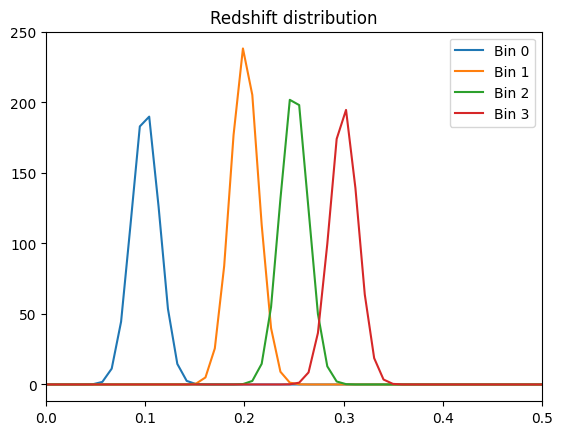

In [4]:
from scipy.stats import norm

max_comoving_distance = box_size[2]  # in Mpc/h
max_redshift = (1 / jc.background.a_of_chi(fiducial_cosmo, max_comoving_distance / fiducial_cosmo.h) - 1).squeeze()
z = jnp.linspace(0, max_redshift, 1000)

nz_shear = [
    jc.redshift.kde_nz(
        z, norm.pdf(z, loc=z_center, scale=0.01), bw=0.01, zmax=max_redshift, gals_per_arcmin2=g
    )
    for z_center, g in zip([0.1, 0.2, 0.25, 0.3], [7, 8.5, 7.5, 7])
]
nbins = len(nz_shear)


# Plotting the redshift distribution
z = jnp.linspace(0, 1.2, 128)

for i in range(nbins):
    plt.plot(
        z,
        nz_shear[i](z) * nz_shear[i].gals_per_arcmin2,
        color=f"C{i}",
        label=f"Bin {i}",
    )
plt.legend()
plt.xlim(0, 0.5)
plt.title("Redshift distribution")
plt.show()


## 2. Running the Spherical Simulation

The simulation setup is similar to the Cartesian case, but the `saveat` function now uses `spherical_density_fn` to paint particles onto Healpix maps.



In [5]:
t0 = 0.1  # Initial scale factor
t1 = 1.0  # Final scale factor
dt0 = 0.05  # Initial time step

@jax.jit
def run_simulation(cosmo):
    # Create a small function to generate the matter power spectrum
    k = jnp.logspace(-4, 1, 128)
    pk = jc.power.linear_matter_power(cosmo, k)
    pk_fn = lambda x: jnp.interp(x.reshape([-1]), k, pk).reshape(x.shape)

    # Create initial conditions
    initial_conditions = linear_field(mesh_shape, box_size, pk_fn, seed=jax.random.PRNGKey(0))    
    # Initial displacement
    dx, p, f = lpt(cosmo, initial_conditions, particles=None,a=0.1,order=1)
    
    # Evolve the simulation forward
    drift , kick = symplectic_ode(mesh_shape, paint_absolute_pos=False)
    ode_fn = ODETerm(kick), ODETerm(drift)
    solver = SemiImplicitEuler()


    a_init = t0
    n_lens = int((box_size[-1] - observer_position[-1]) // d_R)
    r = jnp.linspace(0.0, box_size[-1] - observer_position[-1], n_lens + 1)
    r_center = 0.5 * (r[1:] + r[:-1])
    a_center = jc.background.a_of_chi(cosmo, r_center)
    saveat = SaveAt(ts=a_center[::-1], fn=spherical_density_fn(
        mesh_shape, box_size, nside, observer_position, d_R
    ))

    stepsize_controller = ConstantStepSize()
    res = diffeqsolve(ode_fn,
                      solver,
                      t0=t0,
                      t1=t1,
                      dt0=dt0,
                      y0=(p , dx),
                      args=cosmo,
                      saveat=saveat,
                      stepsize_controller=stepsize_controller)

    density_planes = res.ys
    return initial_conditions ,  dx , density_planes , res.stats

initial_conditions , lpt_displacements , density_planes , solver_stats = run_simulation(fiducial_cosmo)


Shell comoving distance range: [350.] - [400.]
Shell comoving distance range: [300.33322604] - [350.33322604]
Shell comoving distance range: [250.] - [300.]
Shell comoving distance range: [200.91680037] - [250.91680037]
Shell comoving distance range: [150.] - [200.]
Shell comoving distance range: [101.56281485] - [151.56281485]
Shell comoving distance range: [50.] - [100.]
Shell comoving distance range: [0.] - [50.]


## 3. Visualizing Spherical Density Planes

We visualize the extracted spherical density planes using `healpy.mollview`. Each map represents the projected matter density on a spherical shell.


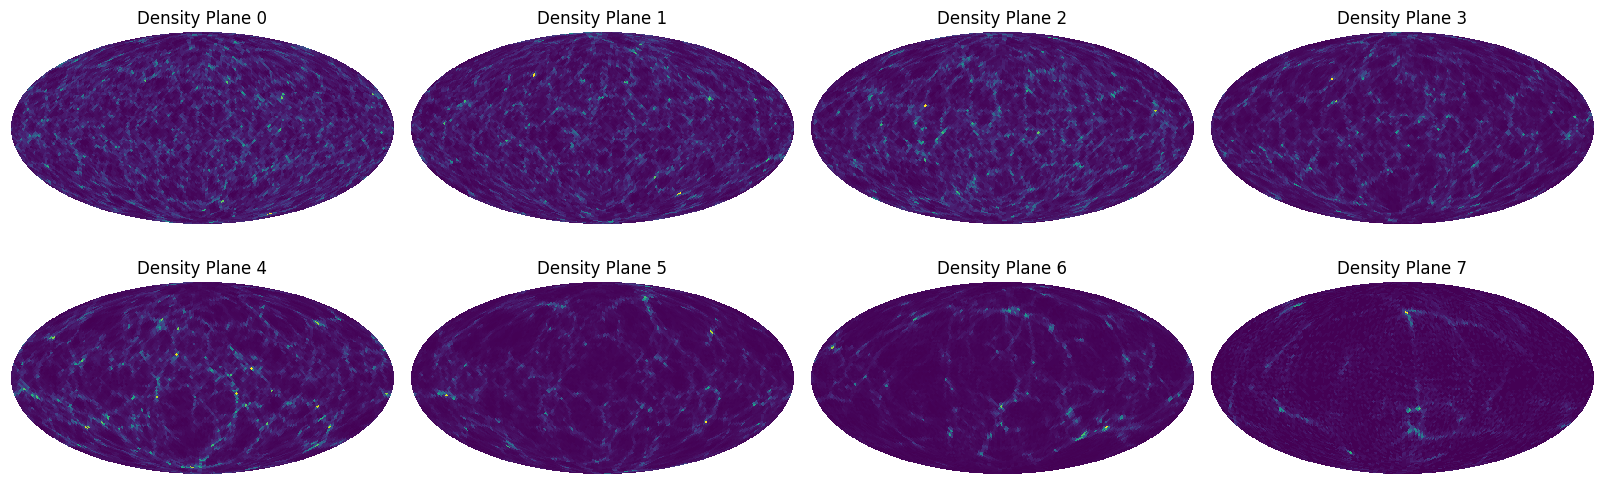

In [6]:
import healpy as hp
fig = plt.figure(figsize=(16, 10))
for i , density_plane in enumerate(density_planes):
    hp.mollview(
        density_plane,
        title=f"Density Plane {i}",
        cmap="viridis",
        sub=(4 , 4 , i + 1),
        bgcolor=(0,)*4,
        cbar=False)

## 4. Computing Spherical Convergence Maps

Finally, we compute the spherical weak lensing convergence maps using the `spherical_convergence_Born` function. These maps represent the integrated lensing signal on the sphere.


In [7]:
def compute_spherical_convergence(density_planes, cosmo, nside, min_redshift=0.0 , max_redshift=2.0):
    n_lens = int((box_size[-1] - observer_position[-1]) // d_R)
    r = jnp.linspace(0.0, box_size[-1] - observer_position[-1], n_lens + 1)
    r_center = 0.5 * (r[1:] + r[:-1])
    a_center = jc.background.a_of_chi(cosmo, r_center)

    lightcone = density_planes

    lightcone = lightcone[::-1]
    # lightcone = jnp.transpose(lightcone, axes=(1, 2, 0)) # Not needed for spherical maps

    convergence_maps = [
                simps(
                    lambda z: nz(z).reshape([-1, 1])
                    * spherical_convergence_Born(fiducial_cosmo, lightcone, r_center, a_center, nside, z),
                    min_redshift,
                    max_redshift,
                    N=32,
                )
                for nz in nz_shear
            ]
    return convergence_maps

kappas = compute_spherical_convergence(density_planes, fiducial_cosmo, nside)

fig = plt.figure(figsize=(16, 10))
for i, kappa in enumerate(kappas):
    hp.mollview(
        kappa,
        title=f"Convergence Map {i}",
        cmap="viridis",
        sub=(2, 2, i + 1),
        bgcolor=(0,)*4,
        cbar=False)

plt.tight_layout()
plt.show()

/tmp/ipykernel_94431/2666366286.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
